In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset = '/content/drive/MyDrive/Dataset'

In [4]:
import os
CATEGORIES = []

for i in os.listdir(dataset):
    CATEGORIES.append(i)

print(CATEGORIES)

['mask_weared_incorrect', 'with_mask', 'without_mask']


In [5]:
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [6]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(dataset, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path)
        TRAIN_DATA.append([img_arr, class_num])

print(len(TRAIN_DATA))

100%|██████████| 2994/2994 [01:04<00:00, 46.59it/s] 

8982


In [7]:

random.shuffle(TRAIN_DATA)


In [8]:
X = []
y = []

for features, label in TRAIN_DATA:
    X.append(features)
    y.append(label)

import numpy as np
X = np.array(X)
y = np.array(y)


In [9]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (8982, 128, 128, 3)
y shape: (8982,)


In [10]:
from keras.utils import to_categorical


y_encoded = to_categorical(y, num_classes=3)


In [11]:
x_train = X.astype("float32") / 255.0

In [12]:
import tensorflow as tf
x_train_resized = tf.image.resize(x_train, (224, 224))




In [13]:
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

num_classes = 3


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.summary()



9406464/9406464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [14]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [15]:
h = model.fit(x_train_resized, y_encoded, batch_size=64, epochs=50, validation_split=0.2)

Epoch 1/50
113/113 [==============================] - 80s 310ms/step - loss: 0.1364 - accuracy: 0.9541 - val_loss: 6.0836 - val_accuracy: 0.5999
Epoch 2/50
113/113 [==============================] - 30s 266ms/step - loss: 0.0496 - accuracy: 0.9834 - val_loss: 11.6563 - val_accuracy: 0.4385
Epoch 3/50
113/113 [==============================] - 31s 271ms/step - loss: 0.0222 - accuracy: 0.9933 - val_loss: 12.1523 - val_accuracy: 0.4936
Epoch 4/50
113/113 [==============================] - 31s 275ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 1.9717 - val_accuracy: 0.8536
Epoch 5/50
113/113 [==============================] - 31s 275ms/step - loss: 0.0334 - accuracy: 0.9900 - val_loss: 0.6778 - val_accuracy: 0.8987
Epoch 6/50
113/113 [==============================] - 31s 276ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.3772 - val_accuracy: 0.9471
Epoch 7/50
113/113 [==============================] - 31s 271ms/step - loss: 0.0126 - accuracy: 0.9965 - val_loss: 0.5504 - val_

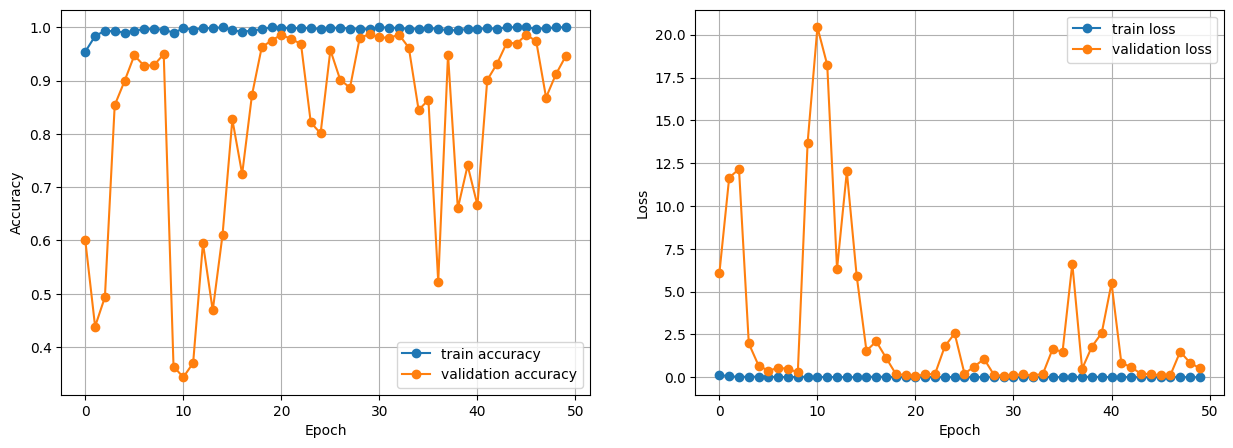

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [20]:
model.save('./content/drive/MyDrive/saved_models/final_model.h5')

#model.save("final_model", save_format="h5")


In [26]:
import os
import cv2
import urllib.request

# URL to the Haar Cascade XML file for face detection
haarcascade_url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'

# Get the directory where your model is saved
model_directory = './content/drive/MyDrive/saved_models/'

# Combine with the XML filename
xml_filename = 'haarcascade_frontalface_default.xml'
xml_file_path = os.path.join(model_directory, xml_filename)

# Download the Haar Cascade XML file
urllib.request.urlretrieve(haarcascade_url, xml_file_path)

# Load the Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(xml_file_path)

# Now you can use the face_cascade for face detection


In [34]:
import cv2
import numpy as np
from keras.models import load_model

# Load the SavedModel
model_path = './content/drive/MyDrive/saved_models/final_model.h5'
loaded_model = load_model(model_path)

# Load the face cascade classifier
face_classifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")



In [37]:
mask_detection = './content/drive/MyDrive/saved_models/final_model.h5'

text_mask = "Mask On"
text_no_mask = "Mask Off"
font = cv2.FONT_HERSHEY_SIMPLEX
scale = 0.8
def predict(image):

    face_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face_frame = cv2.resize(face_frame, (224, 224))
    face_frame = img_to_array(face_frame)
    face_frame = np.expand_dims(face_frame, axis=0)
    face_frame =  preprocess_input(face_frame)

    prediction = mask_detection.predict(face_frame)

    return prediction[0][0]

In [38]:
def detector(gray_image, frame):

    faces = face_classifier.detectMultiScale(gray_image, 1.1, 5)

    for (x,y,w,h) in faces:

        roi_color = frame[y:y+h, x:x+w]
        mask = predict(roi_color)


        if mask > 0.5:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(frame, text =text_mask, org =(x+50,y-100), fontFace =font, fontScale = scale, color =(0,255,0),
            thickness = 2)

        elif mask <= 0.5:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0,0,255), 2)
            cv2.putText(frame, text =text_no_mask, org =(x+50,y-100), fontFace =font, fontScale = scale , color =(0,0,255),
            thickness = 2)

    return frame

In [39]:
video_cap = cv2.VideoCapture(0)

while True:

    ret, frame = video_cap.read()
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    detect = detector(gray_frame, frame)

    cv2.imshow("Video", detect)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

video_cap.release()
cv2.destroyAllWindows()

error: ignored